# Remove unused data from the EEG Recording
Even before doing preprocessing we will remove all unused noisy data from our recording. This includes everything that happened before or in between resting states, before or after the tapping task, or during tapping task breaks. 

This code will require a range of parameters to take data for one participant and export a cleaned data recording with only relevant data.

In [ ]:
%pip install mne numpy matplotlib PyQt5 scikit-learn


In [1]:
# Perform required imports
import os
import PyQt5
import mne
import matplotlib.pyplot as plt
import numpy as np
from mne.preprocessing import ICA
import sklearn
from mne.time_frequency import psd_array_welch
%matplotlib qt


In [20]:
# Set the participant ID
participant_id = "P05"

# Construct the folder path
folder_path = f'Pilot Data/{participant_id}/'

# Find the first .vhdr file in the folder
vhdr_files = [f for f in os.listdir(folder_path) if f.endswith('.vhdr')]
if not vhdr_files:
    raise FileNotFoundError(f"No .vhdr file found in {folder_path}")
eeg_file = os.path.join(folder_path, vhdr_files[0])

# Load the EEG data
raw = mne.io.read_raw_brainvision(eeg_file, preload=True)

# Get the events and event_id dictionary
events, event_id = mne.events_from_annotations(raw)


Extracting parameters from Pilot Data/P05/Apathy_Agency_2025-02-14_14-56-07.vhdr...
Setting channel info structure...
Reading 0 ... 6641242  =      0.000 ...  6641.242 secs...
Used Annotations descriptions: [np.str_('Marker/Impedance'), np.str_('New Segment/'), np.str_('Stimulus/s1'), np.str_('Stimulus/s100'), np.str_('Stimulus/s106'), np.str_('Stimulus/s107'), np.str_('Stimulus/s108'), np.str_('Stimulus/s109'), np.str_('Stimulus/s110'), np.str_('Stimulus/s111'), np.str_('Stimulus/s114'), np.str_('Stimulus/s115'), np.str_('Stimulus/s116'), np.str_('Stimulus/s117'), np.str_('Stimulus/s118'), np.str_('Stimulus/s119'), np.str_('Stimulus/s122'), np.str_('Stimulus/s123'), np.str_('Stimulus/s124'), np.str_('Stimulus/s125'), np.str_('Stimulus/s126'), np.str_('Stimulus/s127'), np.str_('Stimulus/s128'), np.str_('Stimulus/s129'), np.str_('Stimulus/s130'), np.str_('Stimulus/s131'), np.str_('Stimulus/s132'), np.str_('Stimulus/s133'), np.str_('Stimulus/s134'), np.str_('Stimulus/s135'), np.str_('Sti

C:\Users\mijsters\AppData\Local\Temp\ipykernel_34104\3627432001.py:14: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_brainvision(eeg_file, preload=True)


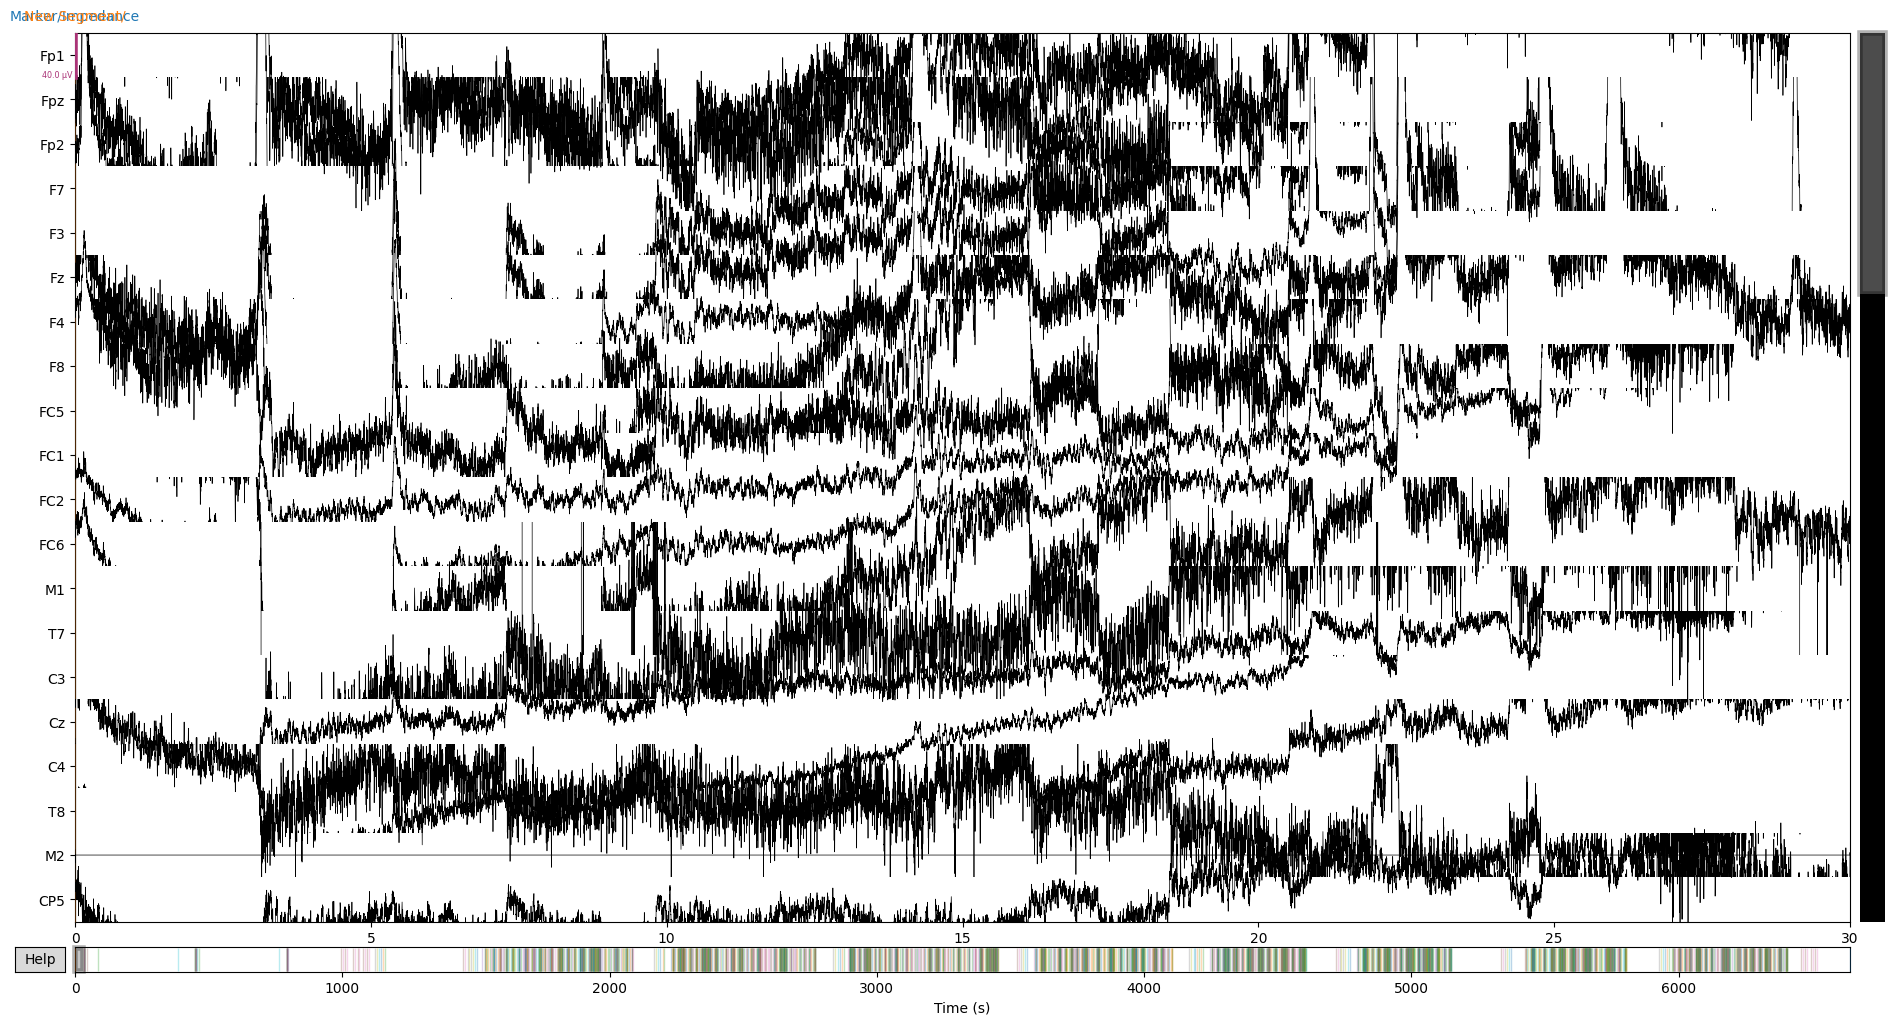

In [21]:
raw.plot(duration=30, title='Raw Recoding')

In [22]:
# Complete the following variables with rough timepoint estimates (can be ~5 seconds off) so we can cut the data

start_point_rs_1 = 85
start_point_rs_2 = 461

start_point_tb_1 = 1452
end_point_tb_1 = 2088

start_point_tb_2 = 2166
end_point_tb_2 = 2770

start_point_tb_3 = 2836
end_point_tb_3 = 3453

start_point_tb_4 = 3525
end_point_tb_4 = 4108

start_point_tb_5 = 4168
end_point_tb_5 = 4608

start_point_tb_6 = 4716
end_point_tb_6 = 5149

start_point_tb_7 = 5332
end_point_tb_7 = 5805

start_point_tb_8 = 5927
end_point_tb_8 = 6407

Helper functions to find events closest before/after the start and end times we have manually indicated

In [23]:
def find_event_after_time(events, time_sec, raw, event_name=None, event_id=None):
    #Find the first event after a given time.
    sample_time = raw.time_as_index(time_sec)[0]
    
    for ev in events:
        if ev[0] >= sample_time:
            if event_name is None:
                return ev
            elif event_id is not None and ev[2] == event_id.get(event_name):
                return ev
    return None

def find_event_before_time(events, time_sec, raw, event_name=None, event_id=None):
    #Find the last event before a given time.
    sample_time = raw.time_as_index(time_sec)[0]
    
    for ev in reversed(events):
        if ev[0] <= sample_time:
            if event_name is None:
                return ev
            elif event_id is not None and ev[2] == event_id.get(event_name):
                return ev
    return None


Extract the exact data for both resting states, starting with Stimulus/s1 and ending with Stimulus/s255

In [24]:
# Find Stimulus/s1 event after each start_point
event_name_start = 'Stimulus/s1'
event_name_end = 'Stimulus/s255'

# RS1
start_event_rs1 = find_event_after_time(events, start_point_rs_1, raw, event_name=event_name_start, event_id=event_id)
if start_event_rs1 is None:
    print("No starting event found for rs1!")
else:
    start_sample_rs1 = start_event_rs1[0]
    start_time_rs1 = raw.times[start_sample_rs1]
    end_time_rs1 = start_time_rs1 + 300  # 300 seconds later
    
    # Find the corresponding end event (s255), but ensure it's after 300 sec
    end_event_rs1 = find_event_after_time(events, end_time_rs1, raw, event_name=event_name_end, event_id=event_id)
    if end_event_rs1 is None:
        print("No ending event found for rs1!")
    else:
        end_sample_rs1 = end_event_rs1[0]

# RS2
start_event_rs2 = find_event_after_time(events, start_point_rs_2, raw, event_name=event_name_start,
                                        event_id=event_id)
if start_event_rs2 is None:
    print("No starting event found for rs2!")
else:
    start_sample_rs2 = start_event_rs2[0]
    start_time_rs2 = raw.times[start_sample_rs2]
    end_time_rs2 = start_time_rs2 + 300
    
    end_event_rs2 = find_event_after_time(events, end_time_rs2, raw, event_name=event_name_end, event_id=event_id)
    if end_event_rs2 is None:
        print("No ending event found for rs2!")
    else:
        end_sample_rs2 = end_event_rs2[0]

rest1 = raw.copy().crop(tmin=raw.times[start_sample_rs1], tmax=raw.times[end_sample_rs1])
rest2 = raw.copy().crop(tmin=raw.times[start_sample_rs2], tmax=raw.times[end_sample_rs2])

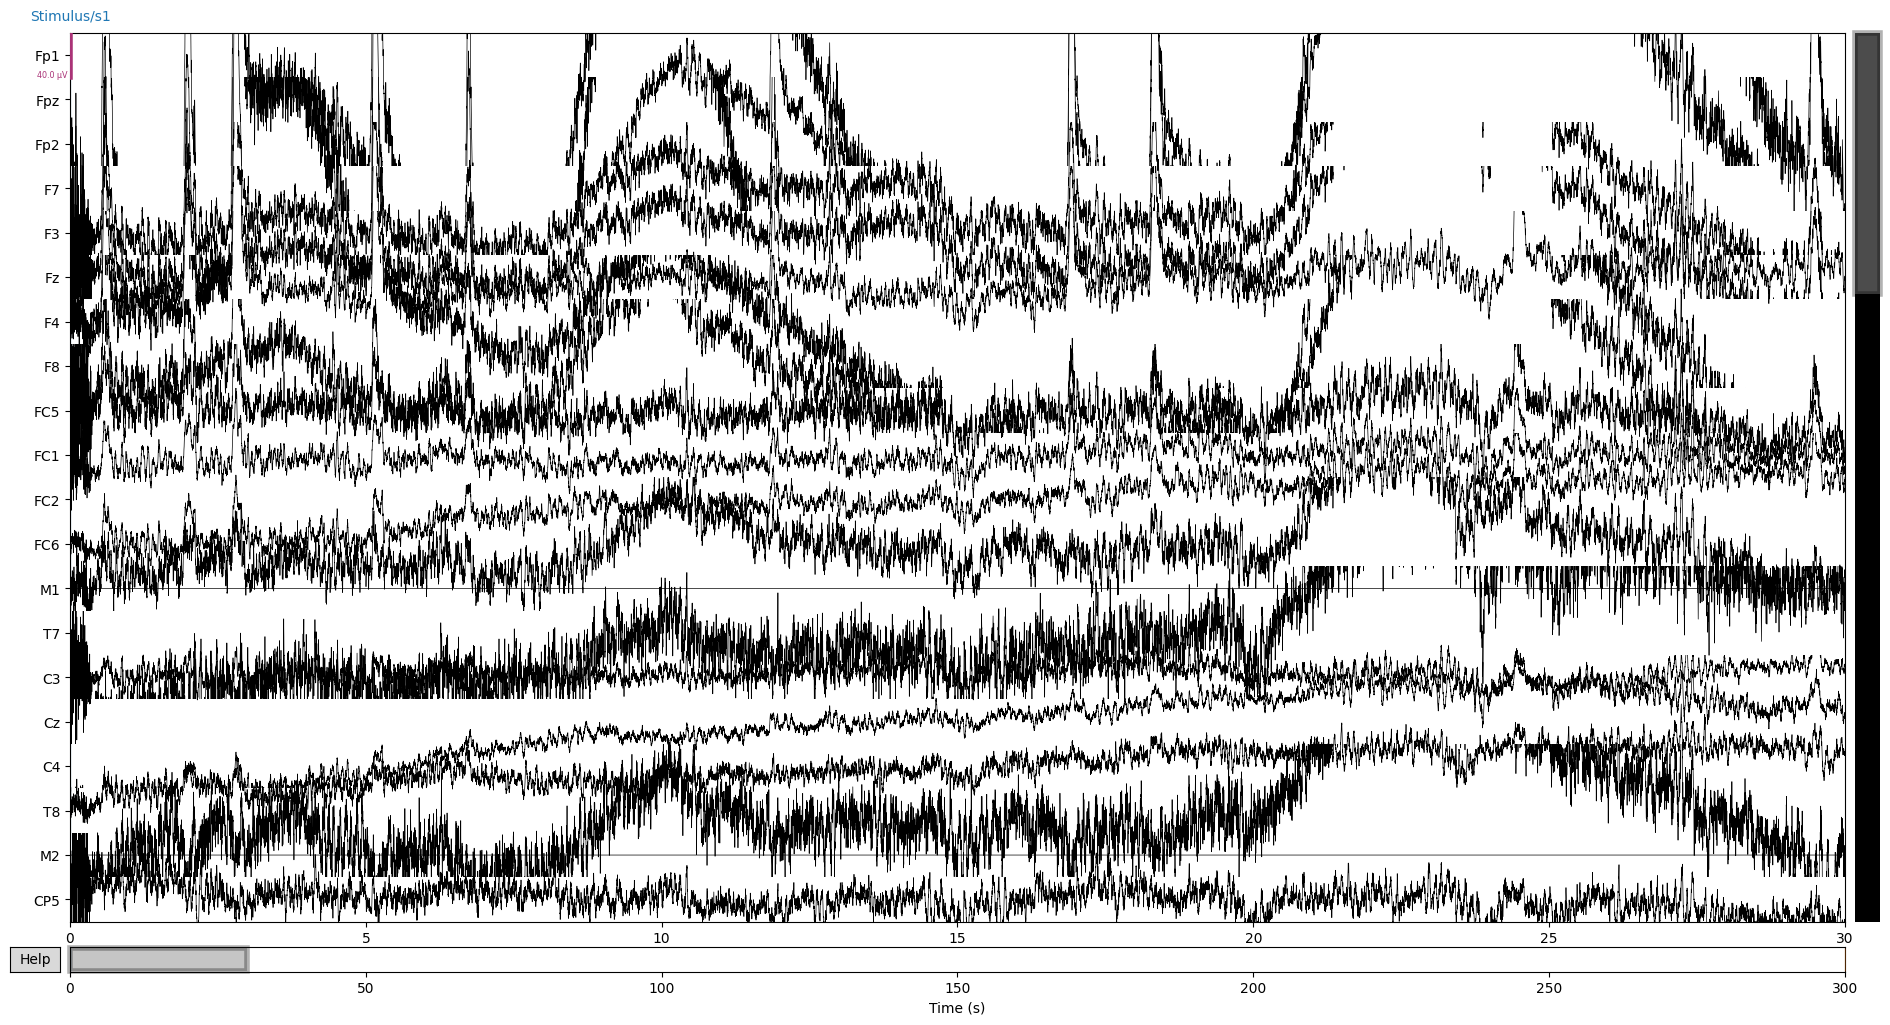

Channels marked as bad:
none
Channels marked as bad:
none


In [25]:
rest1.plot(duration=30, title='Raw Recoding')

Extract the exact data for trial blocks, starting with the first stimulus after the timeslot and ending with the last stimulus before the end time

In [28]:
# Example list of start and end times
start_points_tb = [start_point_tb_1, start_point_tb_2, start_point_tb_3, start_point_tb_4, start_point_tb_5, start_point_tb_6, start_point_tb_7, start_point_tb_8]
end_points_tb = [end_point_tb_1, end_point_tb_2, end_point_tb_3, end_point_tb_4, end_point_tb_5, end_point_tb_6, end_point_tb_7, end_point_tb_8]

trial_blocks = []

for i in range(8):
    start_event = find_event_after_time(events, start_points_tb[i], raw)
    end_event = find_event_before_time(events, end_points_tb[i], raw)

    if start_event is None or end_event is None:
        print(f"No valid events for trial block {i+1}!")
        continue
    
    start_sample = start_event[0]
    end_sample = end_event[0]
    
    tb = raw.copy().crop(tmin=raw.times[start_sample], tmax=raw.times[end_sample])
    trial_blocks.append(tb)


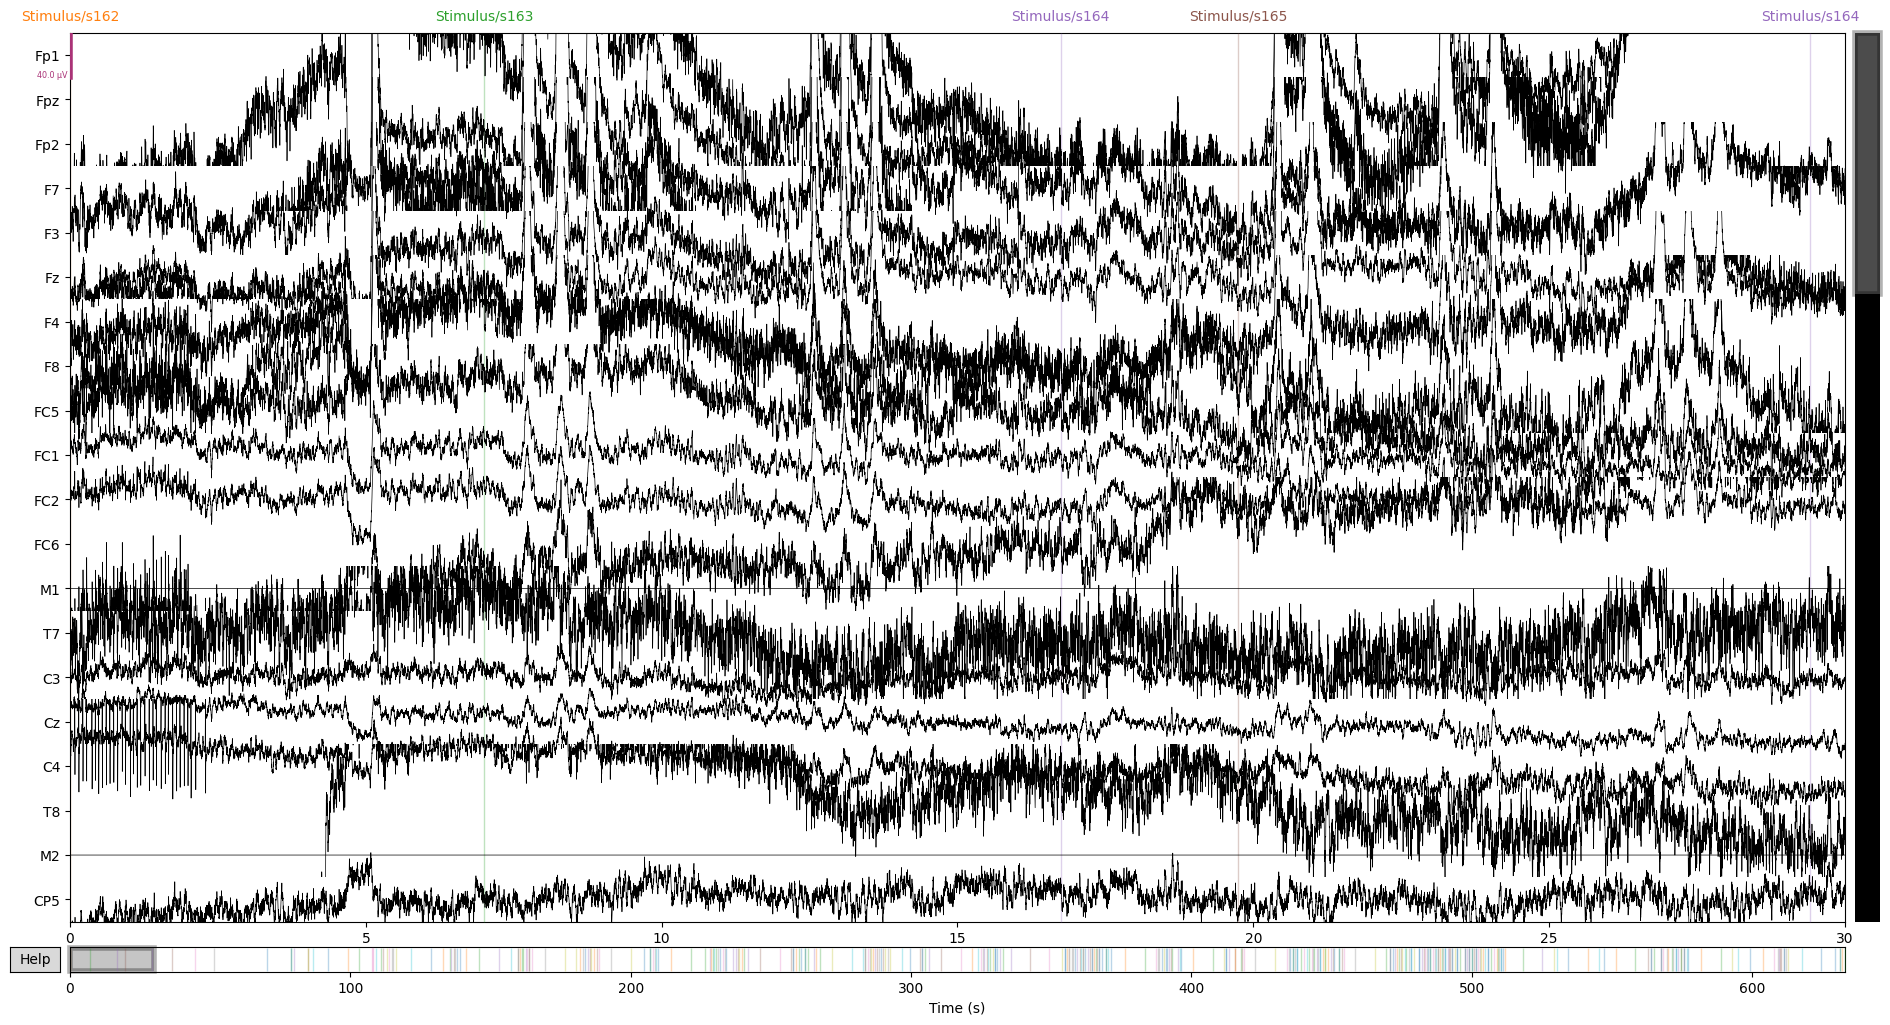

Channels marked as bad:
none


In [ ]:
trial_blocks[0].plot(duration=30, title='Raw Recoding')

Merge data blocks and export

Boundaries are defined using "EDGE and BAD boundaries"

In [ ]:
# Combine all parts into a list
all_parts = [rest1, rest2] + trial_blocks

for i, part in enumerate(all_parts):
    print(f"Segment {i+1}: {part}")

# Concatenate all EEG parts into one Raw object
raw_combined = mne.concatenate_raws(all_parts)

# Save the combined raw file
raw_combined.save(f'Combined Raw Data/combined_raw_{participant_id}.fif', overwrite=True)

print(raw_combined.annotations)


Segment 1: <RawBrainVision | Apathy_Agency_2025-02-14_14-56-07.eeg, 68 x 300010 (300.0 s), ~155.7 MiB, data loaded>
Segment 2: <RawBrainVision | Apathy_Agency_2025-02-14_14-56-07.eeg, 68 x 300009 (300.0 s), ~155.7 MiB, data loaded>
Segment 3: <RawBrainVision | Apathy_Agency_2025-02-14_14-56-07.eeg, 68 x 633103 (633.1 s), ~328.5 MiB, data loaded>
Segment 4: <RawBrainVision | Apathy_Agency_2025-02-14_14-56-07.eeg, 68 x 601855 (601.9 s), ~312.3 MiB, data loaded>
Segment 5: <RawBrainVision | Apathy_Agency_2025-02-14_14-56-07.eeg, 68 x 614937 (614.9 s), ~319.1 MiB, data loaded>
Segment 6: <RawBrainVision | Apathy_Agency_2025-02-14_14-56-07.eeg, 68 x 580303 (580.3 s), ~301.1 MiB, data loaded>
Segment 7: <RawBrainVision | Apathy_Agency_2025-02-14_14-56-07.eeg, 68 x 435657 (435.7 s), ~226.1 MiB, data loaded>
Segment 8: <RawBrainVision | Apathy_Agency_2025-02-14_14-56-07.eeg, 68 x 430476 (430.5 s), ~223.4 MiB, data loaded>
Segment 9: <RawBrainVision | Apathy_Agency_2025-02-14_14-56-07.eeg, 68 x

C:\Users\mijsters\AppData\Local\Temp\ipykernel_34104\2473334050.py:11: RuntimeWarning: This filename (c:\Users\mijsters\Documents\Experiments\Cognitive EBDM\EEG Pilot\EEG Data Analysis\combined_raw_P05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_combined.save(f'combined_raw_{participant_id}.fif', overwrite=True)


Closing c:\Users\mijsters\Documents\Experiments\Cognitive EBDM\EEG Pilot\EEG Data Analysis\combined_raw_P05.fif
[done]
<Annotations | 2927 segments: BAD boundary (9), EDGE boundary (9), ...>


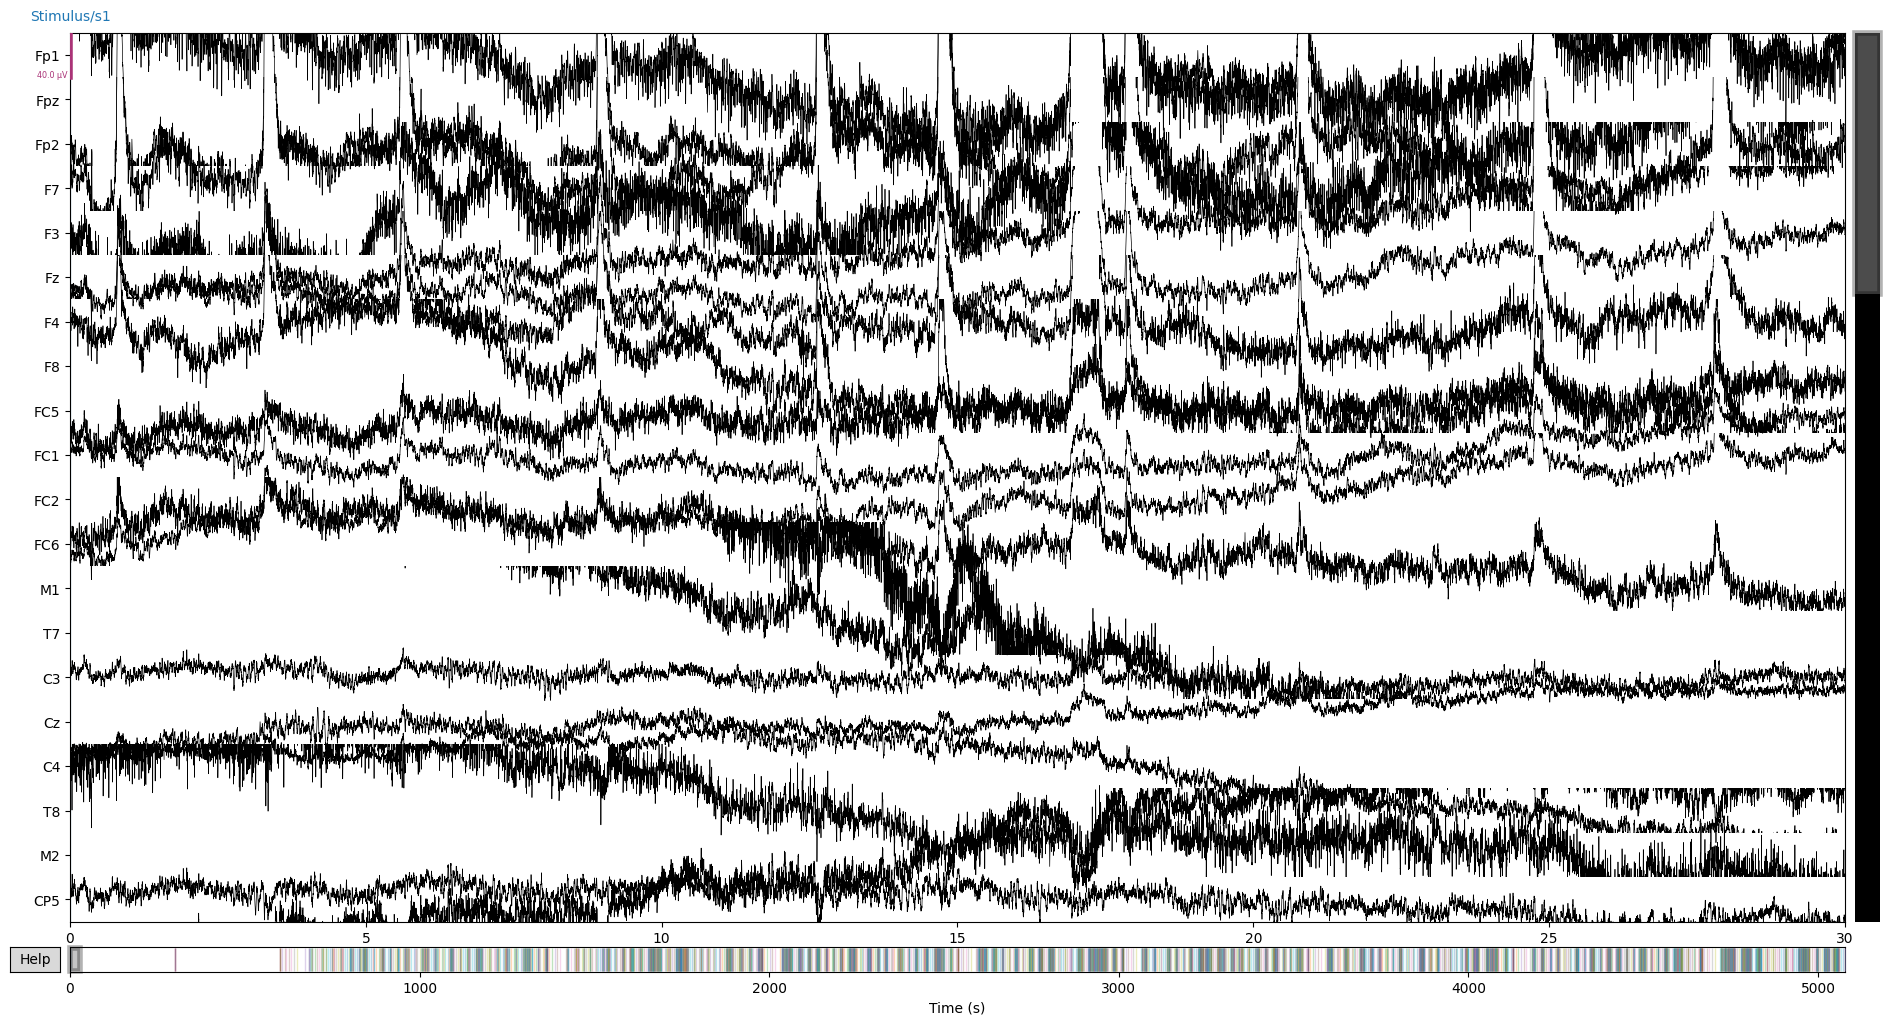

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
raw_combined.plot(duration=30, title='Raw Recoding')